In [3]:
from rdrobust import rdrobust,rdplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from scipy import stats
import warnings
import statsmodels.api as sm_api

# Regression Discontinuity Design - Problem Set

In this problem set, we will explore the RDD method using the library rdrobust and we will follow closely the implementation that you can find [here](https://github.com/rdpackages-replication/T_2021_PPRN). 

Political scientists have long studied the question of whether the incumbent status of previously elected
legislators translates into an electoral or incumbency advantage. This advantage is believed to stem from a
variety of factors, including name recognition, the ability to perform casework and cultivate a personal
vote, the ability to deter high-quality challengers, the implementation of pro-incumbent redistricting plans,
and the availability of the incumbency cue amidst declining party attachments. 

Lee (2008) proposed using a regression discontinuity design based on the discontinuous relationship
between the incumbency status of a party in a given election and its vote share in the previous
election: in a two-party system, a party enjoys incumbency status when it obtains 50% of the vote or more
in the previous election, but loses incumbency status to the opposing party otherwise. In this RD design, the
score is the vote share obtained by a party at election t, the cutoff is 50%, and the treatment (incumbent
status) is assigned deterministically based on whether the vote share at t exceeds the cutoff. The outcome of
interest is the party’s vote share in the following election, at t + 1. The design compares districts where the
party barely won election t to districts where the party barely lost election t, and computes the difference in
the vote share obtained by the party in the following election, at t + 1. This difference is the boost in the
party’s vote share obtained by barely winning relative to barely losing, and it is related but different from
the classical notions of incumbency advantage in the Political Science literature.

Cattaneo (2015) applies the RD design in the U.S. Senate analogously to its previous applications in the U.S. House, comparing states where the Democratic party barely won election t to states where the Democratic party barely lost.


**Data**

$Y_i$ - Democratic election outcome at $t+1$.

$T_i$ - whether Democratic party wins election at $t$.

$X_i$ - margin of victory at $t$ ($c=0$)

**Potential Outcomes**

$Y_i(0)$=election outcome at $t+1$ if had not been incumbent.

$Y_i(1)$=election outcome at $t+1$ if had been incumbent.

**Causal inference**

$Y_i(0) \neq Y_i|T_i=0$ and $Y_i(1) \neq Y_i|T_i=1$ 

## Task A

Import the senate data set, and replace all missing values with numpy NaN format. Create variables for $Y$=demvoteshfor2, $X$=demmv, $c$=0. Construct the Treatment variable such that if the margin of victory is negative, then it belongs to the control group. Otherwise, if the margin of victory is positive, it belongs to the treatment group.

In [4]:
df = pd.read_stata('senate.dta')
df.replace(np.nan, "NaN", inplace=False)

,state,year,dopen,population,presdemvoteshlag1,demmv,demvoteshlag1,demvoteshlag2,demvoteshfor1,demvoteshfor2,demwinprv1,demwinprv2,dmidterm,dpresdem
0,Connecticut,1914.0,0.0,1233000,39.159367,-7.688561,NaN,NaN,46.239407,36.097572,NaN,NaN,1.0,1.0
1,Connecticut,1916.0,0.0,1294000,39.159367,-3.923708,42.076942,NaN,36.097572,45.468746,0.0,NaN,0.0,1.0
2,Connecticut,1922.0,0.0,1431000,33.027374,-6.868660,36.097572,46.239407,35.641209,45.598213,0.0,0.0,1.0,0.0
3,Connecticut,1926.0,0.0,1531000,27.5257,-27.668056,45.468746,36.097572,45.598213,48.476063,0.0,0.0,1.0,0.0
4,Connecticut,1928.0,1.0,1577000,27.5257,-8.256968,35.641209,45.468746,48.476063,51.746868,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385,Hawaii,1998.0,0.0,1190472,56.928802,61.359779,71.781334,57.269115,72.684685,75.510117,1.0,1.0,1.0,0.0
1386,Hawaii,2000.0,0.0,1211497,56.928802,48.177929,79.18438,71.781334,75.510117,61.348957,1.0,1.0,0.0,0.0
1387,Hawaii,2004.0,0.0,1273569,55.791672,54.522358,72.684685,79.18438,61.348957,74.807701,1.0,1.0,0.0,0.0
1388,Hawaii,2006.0,0.0,1309731,54.009552,24.569040,75.510117,72.684685,74.807701,NaN,1.0,1.0,1.0,0.0


In [5]:
# Variable selection
df["Y"] = df['demvoteshfor2']
df["X"] = df['demmv']
df["c"] = 0

In [6]:
df["T"] = np.NaN
df.loc[df["X"] < 0, "T"] = 0
df.loc[df["X"] >= 0, "T"] = 1

## Task B

In order to conduct causal inference, we need to make sure that the two groups are comparable. For this, we would want to conduct a hypothesis test to test whether the two groups are statistically different or not.

### Task B.1

Calculate the difference in means of the potential outcomes for both groups and conduct a hypothesis test to test whether this difference is statistically significant.  To compare the two independent means, conduct a two-sample t-test.

**Note**: Before conducting the test statistic, make sure to take into account missing values and treat them properly.

The mean difference, or difference in means, measures the absolute difference between the mean value in two different groups. It gives you an idea of how much difference there is between the averages of the experimental group and control groups.

First, we need to check whether there are any missing values for the outcome variable. If missing values are present, the test statistic cannot be performed.

In [7]:
df["Y"].isnull().sum()

93

We create the outcome variable for treated and control group:

In [9]:
y_treated = df.query("T==1")["Y"]
y_untreated = df.query("T==0")["Y"]

and we drop missing values:

In [10]:
y_treated = y_treated.dropna() 
y_untreated = y_untreated.dropna() 

We compute the difference in means:

In [11]:
diff = y_untreated.mean() - y_treated.mean()
diff

-21.701160430908203

And we run the following hypothesis test to check whether this difference is statistically significant. We observe two independent samples and we are considering whether the two samples were drawn from the same population or two different populations.

The t-test quantifies the difference between the arithmetic means of the two samples. The p-value quantifies the probability of observing as or more extreme values assuming the null hypothesis, that the samples are drawn from populations with the same population means, is true. A p-value larger than a chosen threshold (e.g. 5% or 1%) indicates that our observation is not so unlikely to have occurred by chance. Therefore, we do not reject the null hypothesis of equal population means. If the p-value is smaller than our threshold, then we have evidence against the null hypothesis of equal population means.

$H_0: \mu_1-\mu_2=0$

$H_1: \mu_1-\mu_2 \neq 0$

In [12]:
stats.ttest_ind(y_untreated, y_treated)

Ttest_indResult(statistic=-26.775084134665246, pvalue=4.764436062802627e-126)

We can reject the $H_0$ of equal population means.

## Task B.2

Plot the distributions of the outcomes for both treated and untreated group and make a graphical representation of the differences between the two groups.

In [32]:
%matplotlib inline
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 10,5
rcParams['font.size'] = 15
sns.set()

In [38]:
def plot_distribution(var, color):
    sns.distplot(var, hist=True, kde=True, 
                 bins=int(180 / 5), color=color, 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2})
    
    plt.axvline(var.mean(),
                color=color,
                ymax=1,
                ls='--',
                lw=1.2,
                label="s")

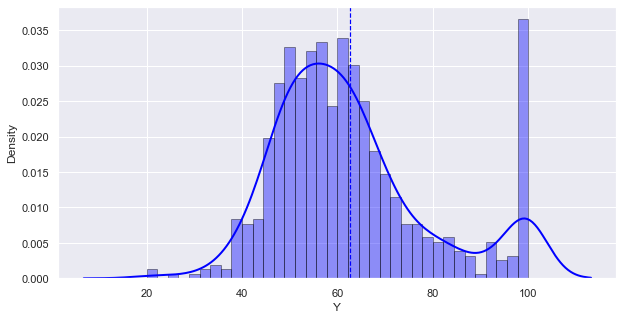

In [39]:
plot_distribution(y_treated, "blue")

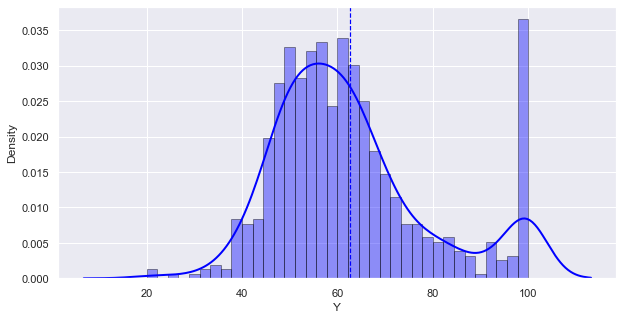

In [35]:
sns.distplot(y_treated, hist=True, kde=True, 
             bins=int(180 / 5), color="blue", 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

plt.axvline(y_treated.mean(),
            color="blue",
            ymax=1,
            ls='--',
            lw=1.2,
            label="s")

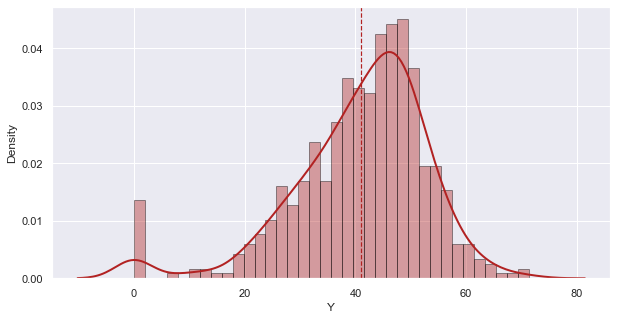

In [40]:
plot_distribution(y_untreated, "firebrick")

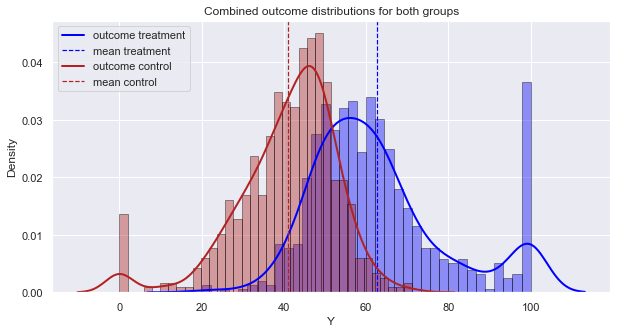

In [42]:
plt.figure()
plot_distribution(y_treated, "blue")
plot_distribution(y_untreated, "firebrick")
plt.title("Combined outcome distributions for both groups")
plt.legend(labels=['outcome treatment','mean treatment', 'outcome control', 'mean control'])
plt.show()

## Taks C


### Task C.1

For the following tasks, use the [rdrobust package](https://rdpackages.github.io/replication/). By splitting the data above and below the cutoff ($C$=0), calculate the mean of the outcome in each bin and plot the results. Explore the results using a linear approximation to fit the data, as well as other degrees of polynomial.

Which of those fits the data better? 

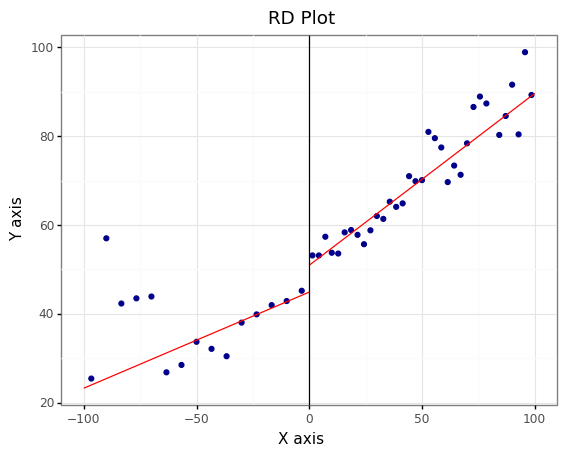


Call: rdplot
Number of Observations:                  1297
Kernel:                               Uniform
Polynomial Order Est. (p):                  1

                                Left      Right
------------------------------------------------
Number of Observations           595        702
Number of Effective Obs          595        702
Bandwith poly. fit (h)         100.0      100.0
Number of bins scale               1          1
Bins Selected                     15         35
Average Bin Length             6.667      2.857
Median Bin Length              6.667      2.857
IMSE-optimal bins                8.0        9.0
Mimicking Variance bins         15.0       35.0

Relative to IMSE-optimal:
Implied scale                  1.875      3.889
WIMSE variance weight          0.132      0.017
WIMSE bias weight              0.868      0.983


In [90]:
rdplot(df["Y"],df["X"], c=0, p=1)

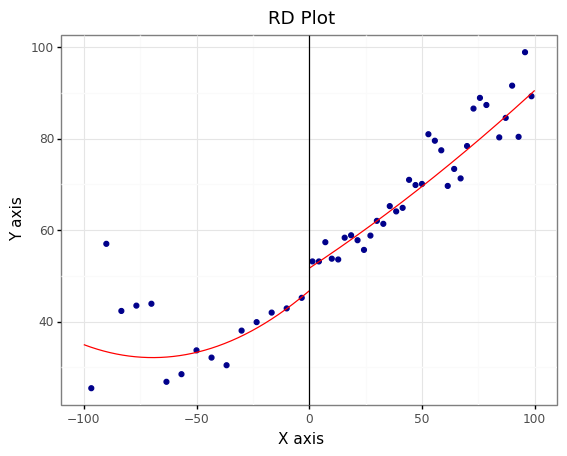


Call: rdplot
Number of Observations:                  1297
Kernel:                               Uniform
Polynomial Order Est. (p):                  2

                                Left      Right
------------------------------------------------
Number of Observations           595        702
Number of Effective Obs          595        702
Bandwith poly. fit (h)         100.0      100.0
Number of bins scale               1          1
Bins Selected                     15         35
Average Bin Length             6.667      2.857
Median Bin Length              6.667      2.857
IMSE-optimal bins                8.0        9.0
Mimicking Variance bins         15.0       35.0

Relative to IMSE-optimal:
Implied scale                  1.875      3.889
WIMSE variance weight          0.132      0.017
WIMSE bias weight              0.868      0.983


In [21]:
rdplot(df["Y"],df["X"], c=0, p=2)

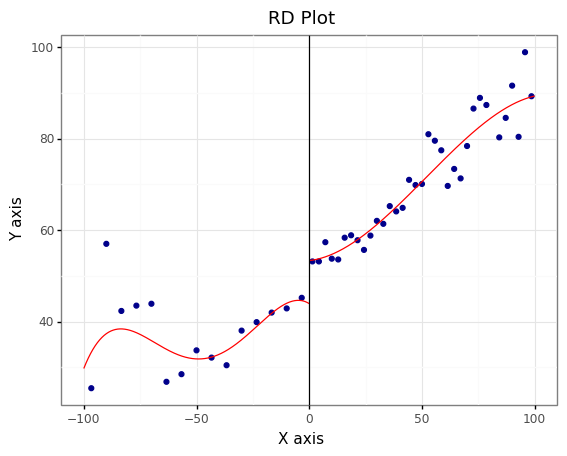


Call: rdplot
Number of Observations:                  1297
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations           595        702
Number of Effective Obs          595        702
Bandwith poly. fit (h)         100.0      100.0
Number of bins scale               1          1
Bins Selected                     15         35
Average Bin Length             6.667      2.857
Median Bin Length              6.667      2.857
IMSE-optimal bins                8.0        9.0
Mimicking Variance bins         15.0       35.0

Relative to IMSE-optimal:
Implied scale                  1.875      3.889
WIMSE variance weight          0.132      0.017
WIMSE bias weight              0.868      0.983


In [79]:
rdplot(df["Y"],df["X"], c=0, p=4)

### Task C.2

By default, the package estimates the number of bins by using any of the methods described in the documentation. Explore the posibility of manually selecting the number of bins and adding a confidence interval for the selected bins. 

Why is in general not recommended to specify the number of bins manually?

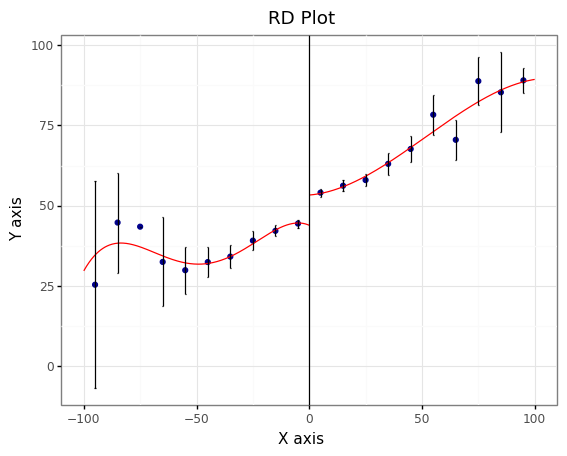


Call: rdplot
Number of Observations:                  1297
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations           595        702
Number of Effective Obs          595        702
Bandwith poly. fit (h)         100.0      100.0
Number of bins scale               1          1
Bins Selected                     10         10
Average Bin Length              10.0       10.0
Median Bin Length               10.0       10.0
IMSE-optimal bins                8.0        9.0
Mimicking Variance bins         15.0       35.0

Relative to IMSE-optimal:
Implied scale                   1.25      1.111
WIMSE variance weight          0.339      0.422
WIMSE bias weight              0.661      0.578


In [31]:
# Select manually number of bins and add confidence intervals
rdplot(df["Y"],df["X"], 
       c=0, 
       nbins=10,
       ci=95)

## Taks D

### Task D.1

Assume you want to estimate the RD estimator by a linear approximation of the data around the cutoff and with a bandwith of 10. Calculate the RD estimator by two means:

* Estimate the linear regression to the left and right of the cutoff and calculate the RD estimator by calculating the differences between the two regression coefficients.

* Estimate the RD estimator by estimating a joint regression.

In [12]:
df_left = df[(df["X"] < 0) & (df["X"] >= -10)]
df_left["Y"].isnull().sum()
df_left = df_left[df_left['Y'].notna()]
df_right = df[(df["X"] >= 0) & (df["X"] <= 10)]
df_right = df_right[df_right['Y'].notna()]

model_left = sm_api.OLS(df_left["Y"], sm_api.add_constant(df_left["X"])).fit()
model_right = sm_api.OLS(df_right["Y"], sm_api.add_constant(df_right["X"])).fit()

print("The RD estimator is", (model_right.params[0] - model_left.params[0]).round(3))

The RD estimator is 6.899


In [91]:
df["T_X"] = df["X"] * df["T"]

df_both = df[(df["X"].abs()) <= 10]
df_both = df_both[df_both['Y'].notna()]

model_joint = sm_api.OLS(df_both["Y"], sm_api.add_constant(df_both[["X", "T", "T_X"]])).fit()

print("The RD estimator for a joint estimation is", (model_joint.params[2]).round(3))

The RD estimator for a joint estimation is 6.899


### Task D.2

Use the rdrobust package to improve the estimations by selecting the optimal bandwith and a linear regression around the cutoff. Think about what type of kernel function to implement, as well as the method to choose the bandwith (could be a MSE-optimal or CER-optimal selection). 

Is the treatment effect different from the one estimated above?

Plot the RD plot again using this time the MSE-optimal selection for the bandwith.

In [77]:
rdrobust(df["Y"], df["X"], kernel="tri", p=1, bwselect="mserd")

Call: rdrobust
Number of Observations:                  1297
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           595        702
Number of Unique Obs.            595        665
Number of Effective Obs.         360        323
Bandwidth Estimation          17.754     17.754
Bandwidth Bias                28.028     28.028
rho (h/b)                      0.633      0.633

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       7.414    1.459    5.083   3.722e-07    [4.555, 10.273]
Robust                 -        -    4.311   1.625e-05    [4.094, 10.919]


In [85]:
df_band = df[(df["X"].abs()) <= 17.754]

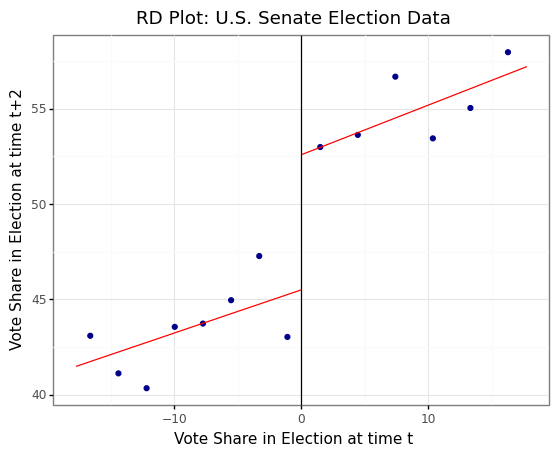


Call: rdplot
Number of Observations:                   683
Kernel:                               Uniform
Polynomial Order Est. (p):                  1

                                Left      Right
------------------------------------------------
Number of Observations           360        323
Number of Effective Obs          360        323
Bandwith poly. fit (h)        17.754     17.754
Number of bins scale               1          1
Bins Selected                      8          6
Average Bin Length             2.218      2.956
Median Bin Length              2.218      2.956
IMSE-optimal bins                8.0        6.0
Mimicking Variance bins         17.0       18.0

Relative to IMSE-optimal:
Implied scale                    1.0        1.0
WIMSE variance weight            0.5        0.5
WIMSE bias weight                0.5        0.5


In [88]:
rdplot(df_band["Y"], df_band["X"], binselect="es", h=17.754, p=1,
       title="RD Plot: U.S. Senate Election Data", 
       y_label="Vote Share in Election at time t+2",
       x_label="Vote Share in Election at time t")

# References

* **Cattaneo, M, Brigham, R.F., and Titiunik, R.(2015)** [Randomization inference in the regression
discontinuity design: an application to party advantages in the U.S. Senate](https://www.degruyter.com/document/doi/10.1515/jci-2013-0010/html), *Journal of Causal Inference*, 3(1), 1-24.


* **Lee, D.S. (2008).** [Randomized experiments from non-random selection in U.S. House elections](https://www.sciencedirect.com/science/article/pii/S0304407607001121), *Journal of Econometrics*, 142(2), 675-697.
